In [40]:
from google.colab import drive # Mount the google drive for data loading
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import required libraries

In [41]:
import numpy as np #helps for array operation
import pandas as pd #helps to read the data
import matplotlib.pyplot as plt #helps with graphical plots
from sklearn.preprocessing import MinMaxScaler #helps for standardation of input data
import keras #helps for CNN model construction
import tensorflow as tf #helps for CNN model construction
import math #helps with calculating evaluation metrics
import sklearn.metrics #helps with calculating evaluation metrics

# 1. Load data using pandas package
Data loading and data visualiazation


In [42]:
training_movies = pd.read_csv('/content/drive/MyDrive/data/training_movies.csv')  # Load data with the corresponding path in google drive

testing_movies = pd.read_csv('/content/drive/MyDrive/data/testing_movies.csv')  # Load data with the corresponding path in google drive

movies_df = pd.concat([training_movies , testing_movies])

In [43]:
print (*movies_df.columns,sep=", ") # Columns names
print("-"*100)
print (movies_df.info())  # Infomation of the dataset

Title, Duration, Budget, Reviews_by_Users, IMDB_Score, Gross_Earnings
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 1874 entries, 0 to 562
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Title             1874 non-null   object 
 1   Duration          1874 non-null   int64  
 2   Budget            1874 non-null   int64  
 3   Reviews_by_Users  1874 non-null   int64  
 4   IMDB_Score        1874 non-null   float64
 5   Gross_Earnings    1874 non-null   int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 102.5+ KB
None


In [44]:
print (movies_df.head())  # Display of the first few samples

                   Title  Duration    Budget  Reviews_by_Users  IMDB_Score  \
0            Beer League        86   2800000                53         6.0   
1            Alias Betty       103  50000000                26         6.9   
2              Antitrust       109  30000000               221         6.1   
3         Vertical Limit       124  75000000               379         5.9   
4  The Forbidden Kingdom       104  55000000               279         6.6   

   Gross_Earnings  
0          475000  
1          206400  
2        10965209  
3        68473360  
4        25040293  


In [45]:
print (testing_movies.shape)   # Size of test dataset
print (training_movies.shape)   # Size of train dataset

print (movies_df.shape) # Size of total dataset

(563, 6)
(1311, 6)
(1874, 6)


In [46]:
movies_df = movies_df.drop(["Title"], axis=1)
testing_movies = testing_movies.drop(["Title"], axis=1)
training_movies = training_movies.drop(["Title"], axis=1)

print (*training_movies.columns,sep=", ") # Columns names
print (*testing_movies.columns,sep=", ") # Columns names
print (*movies_df.columns,sep=", ") # Columns names

Duration, Budget, Reviews_by_Users, IMDB_Score, Gross_Earnings
Duration, Budget, Reviews_by_Users, IMDB_Score, Gross_Earnings
Duration, Budget, Reviews_by_Users, IMDB_Score, Gross_Earnings


## 2. Data Visualization

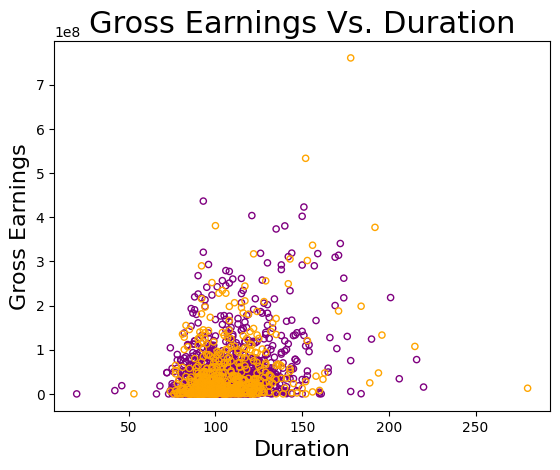

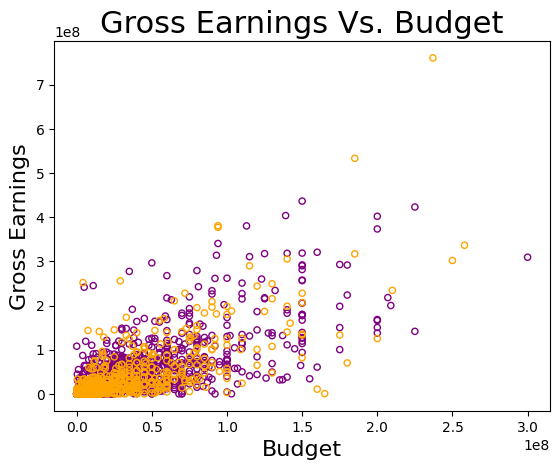

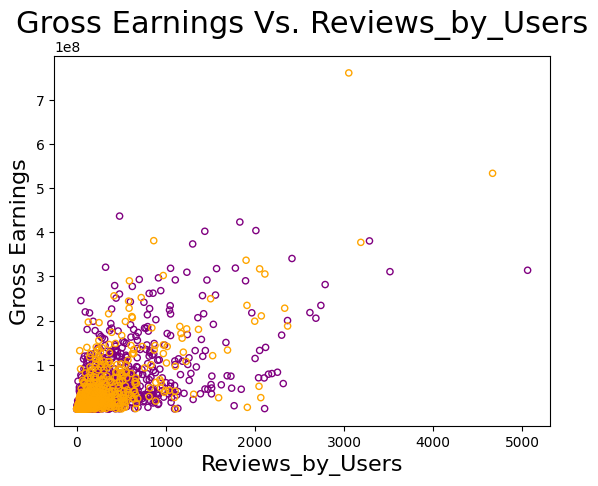

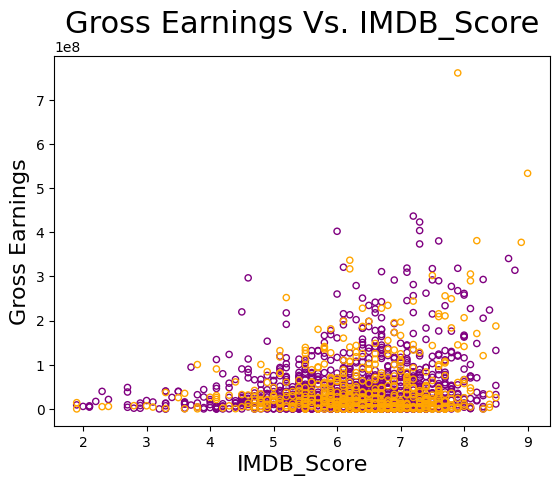

In [47]:
# Visualization
for column in movies_df.columns[:-1]:
  plt.scatter(training_movies[column], training_movies["Gross_Earnings"], s=20, marker="o", edgecolor=["purple"], c="none")  # train
  plt.scatter(testing_movies[column], testing_movies["Gross_Earnings"], s=20, marker="o", edgecolor=["orange"], c="none")  # test
  plt.title("Gross Earnings Vs. "+column, fontsize=22)
  plt.ylabel("Gross Earnings", fontsize=16)
  plt.xlabel(column, fontsize=16)
  plt.show()
  print()

## 3. Reshaping the data in preparation for the CNN

In [48]:
# Transform input data to an array
X_train , Y_train = training_movies.values[:,:-1] , training_movies.values[:,-1:]

# Transform input data to an array
X_test , Y_test = testing_movies.values[:,:-1] , testing_movies.values[:,-1:]

print (X_train.shape)
print (X_test.shape)

(1311, 4)
(563, 4)


## Normalisation

In [49]:
scaler = MinMaxScaler()   #call the standardation package
scaler.fit(X_train)         #fit the raw data
X_train = scaler.transform(X_train).reshape(-1,4,1,1) #normalization of training data
X_test = scaler.transform(X_test).reshape(-1,4,1,1)  #normalization of testing data

Y_train_max = max(Y_train)      #obtain the maximum of training labels for label normalization
Y_train = Y_train/Y_train_max   #normalization of training labels
Y_test = Y_test/Y_train_max     #normalization of testing labels

## Model Training

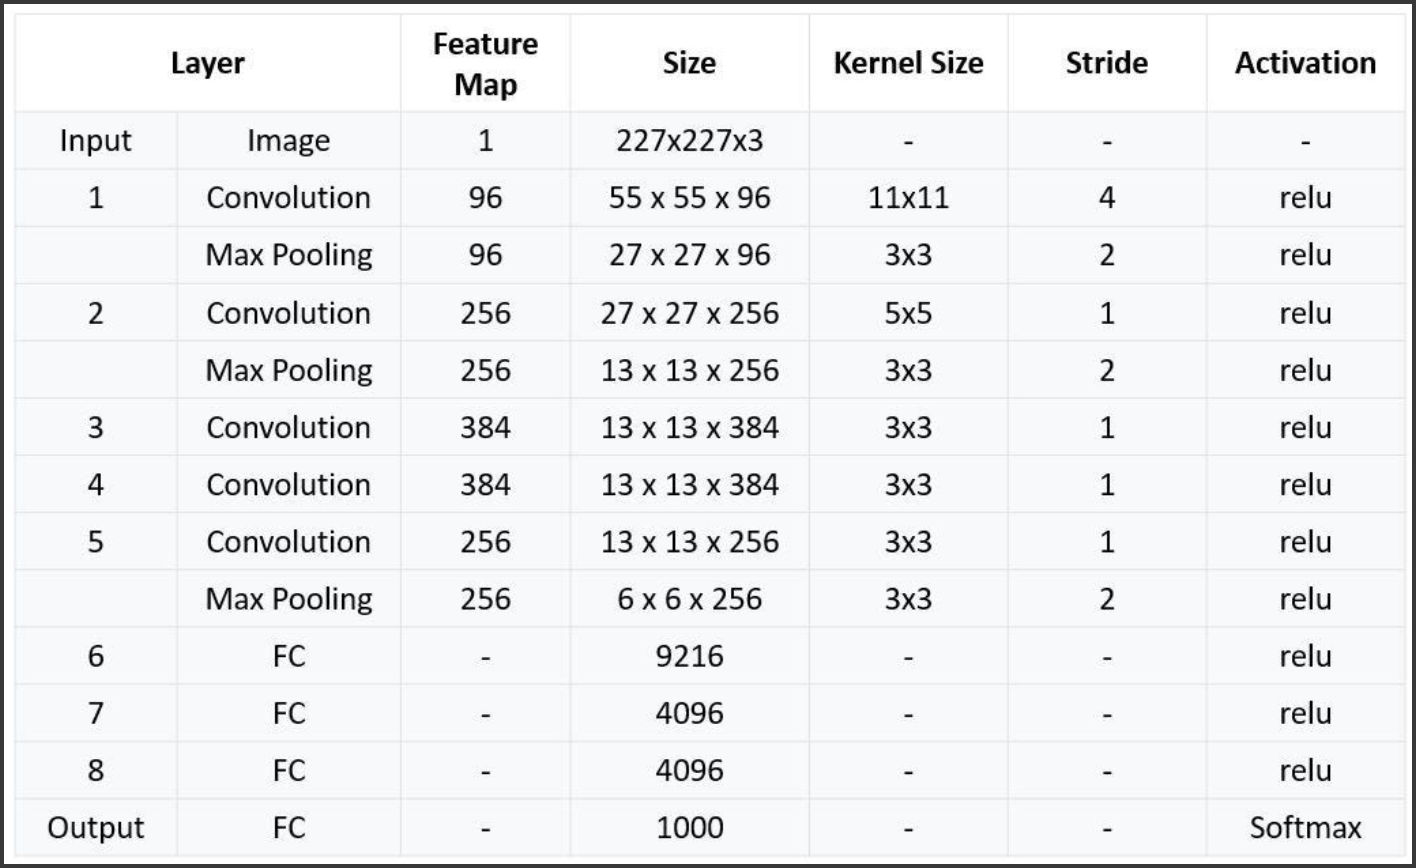

In [50]:
# LeNet-5/AlexNet hybrid structure tailored for regression on tabular data
model = keras.Sequential()

# The first convolutional layer:
# - Uses 12 filters, each with a kernel size of 3x1 to capture patterns across three consecutive features.
# - Strides are set to 1x1, meaning the filter moves one step at a time without skipping any features.
# - Padding is 'same', meaning zero padding is added to preserve the feature dimension after convolution.
# - Activation function is ReLU (Rectified Linear Unit), introducing non-linearity to the model.
model.add(keras.layers.Conv2D(filters=12, kernel_size=(3,1), strides=(1,1), padding='same', activation='relu', input_shape=(4, 1, 1)))

# The first max pooling layer:
# - Reduces the spatial size of the feature map to lower the number of parameters and computation in the network.
# - Pool size is set to 2x1, meaning each feature map is reduced to half its size in one dimension.
# - Strides are set to 2x1, matching the pool size to prevent overlap.
model.add(keras.layers.MaxPool2D(pool_size=(2,1), strides=(2,1)))

# Second and third convolutional layers:
# - Increase the depth of the network, allowing it to learn more complex patterns.
# - The number of filters is increased to 48 and then reduced to 32 for hierarchical feature learning.
# - Kernel size is set to 1x1 to apply a form of feature transformation and combination.
model.add(keras.layers.Conv2D(filters=48, kernel_size=(1,1), strides=(1,1), padding='same', activation='relu'))
model.add(keras.layers.Conv2D(filters=32, kernel_size=(1,1), strides=(1,1), padding='same', activation='relu'))

# Flatten the output of the convolutional layers:
# - Converts the 2D feature maps into a 1D feature vector to be fed into the dense layers.
model.add(keras.layers.Flatten())

# The first fully connected (dense) layer:
# - Consists of 150 neurons and uses the ReLU activation function.
# - This layer begins the high-level reasoning part of the network.
model.add(keras.layers.Dense(150, activation='relu'))

# The second fully connected (dense) layer:
# - A smaller layer with 100 neurons that continues the pattern analysis from the previous layer.
model.add(keras.layers.Dense(100, activation='relu'))

# Output layer for regression:
# - A single neuron with no activation function (linear activation) to predict the continuous target variable (Gross Earnings).
model.add(keras.layers.Dense(1))

# Summary of the model to understand its structure and the number of parameters.
model.summary()

# Compilation of the model:
# - The optimizer used is Stochastic Gradient Descent (SGD).
# - The loss function is mean squared error, which is appropriate for regression problems.
model.compile(optimizer=tf.keras.optimizers.SGD(), loss='mean_squared_error')

# Model training:
# - The model will fit to the training data (X_train, Y_train) across 250 epochs.
# - Batch size is set to 64, meaning 64 samples are used to compute the gradient and update weights in each training step.
# - Verbosity of 2 means that there will be one line output per epoch in the console.
model.fit(X_train, Y_train, epochs=250, batch_size=64, verbose=2)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 4, 1, 12)          48        
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 2, 1, 12)          0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 2, 1, 48)          624       
                                                                 
 conv2d_11 (Conv2D)          (None, 2, 1, 32)          1568      
                                                                 
 flatten_3 (Flatten)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 150)               9750      
                                                      

## Evaluating the model

18/18 [==============================] - 0s 2ms/step


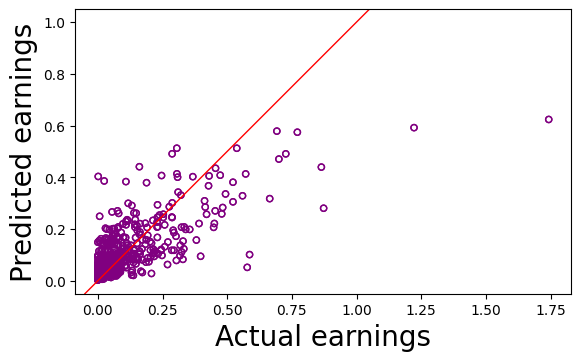

In [51]:
prediction = model.predict(X_test)    # Prediction of the testing set

# Visualization
plt.scatter(Y_test, prediction, s=20, marker="o", edgecolor=["purple"], c="none")
plt.scatter(Y_test, prediction, s=20, marker="o", edgecolor=["purple"], c="none")
plt.xlabel("Actual earnings", fontsize=20)
plt.ylabel("Predicted earnings", fontsize=20)

ax = plt.gca()
ax.set_aspect("equal", adjustable="box")

plt.axline((0, 0), (1, 1), linewidth=1, color="r")

plt.show()

In [52]:
# Calculate the RMSE
mse = sklearn.metrics.mean_squared_error(Y_test, prediction)
rmse = math.sqrt(mse)
print(f"RMSE: {rmse}")

# Calculate the r2
r2 = sklearn.metrics.r2_score(Y_test, prediction)
print(f"R2: {r2}")

RMSE: 0.1075152757240634
R2: 0.5530413869231329
